<a href="https://colab.research.google.com/github/nikarpoff/gender-classification/blob/main/GenderClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Gender classification task**

В данном документе представлено решение для определения пола человека по фотографии на основе нейросетевых моделей.

Для вычисления вектора признаков (эмбеддингов) использовалась модель CLIP ViT-B/16, которая оперирует патчами изображений (каждый патч - 16x16, каждое входящее изображение - 224x224).

На основе вектора признаков своё предположение о поле человека делает многослойный персептрон.

Для тестирования модели необходима модель CLIP:


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-u51opye8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-u51opye8
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 857.7 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

Загрузите модель, обученную на CelebA (200.000 изображений, 5 эпох) и датасет с реальными данными:

In [ ]:
import os

import gdown
import zipfile

import torch
import clip

import pandas as pd

from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms

from PIL import Image


class CustomFacesDataset(Dataset):
    def __init__(self, dataframe, base_path: str):
        self.dataframe = dataframe
        self.base_path = base_path

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get data from dataframe.
        row = self.dataframe.iloc[idx]
        image_path = row['path']
        gender = int(row['gender'])

        # Open image.
        image = Image.open(f"{self.base_path}/{image_path}").convert('RGB')

        # Cast gender to tensor
        gender = torch.tensor(gender, dtype=torch.long)

        # Apply transform.
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        tensor = transform(image)

        target = (gender.unsqueeze(-1).type(torch.float), image_path)

        return tensor, target


# Load model.
output_model = 'model.pth'
output_model_py = 'model.py'
device = torch.device('cuda')

if not os.path.exists(output_model_py):
    url_model = "https://drive.google.com/uc?export=download&id=1gSQvKWJoRDJ5sC_lN0x2RNazEqyjZkOL"
    gdown.download(url_model, output_model_py, quiet=False)

from model import GenderClassifier

if not os.path.exists(output_model):
    url_model = "https://drive.google.com/uc?export=download&id=1dWBZar9KT9BqPmsyHqf1FUPtNsopHX6D"
    gdown.download(url_model, output_model, quiet=False)

model = torch.load(output_model)

# Load dataset.
output_images = 'images.zip'
output_data = 'data.csv'

if not os.path.exists(output_images):
    url_images = "https://drive.google.com/uc?export=download&id=15dxFSC0-wJrhG7M-OdeWW08lg0stXkMl"
    gdown.download(url_images, output_images, quiet=False)

    with zipfile.ZipFile(output_images, 'r') as zip_ref:
      zip_ref.extractall('/content/images')

if not os.path.exists(output_data):
    url_data = "https://drive.google.com/uc?export=download&id=1EEMy97BZF9sKARdrSZLXMIvBGNzugyy4"
    gdown.download(url_data, output_data, quiet=False)

# Read csv.
base_path = '/content/images'
df = pd.read_csv('data.csv')

# Initialize dataset and dataloader.
data = CustomFacesDataset(df, base_path=base_path)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1gSQvKWJoRDJ5sC_lN0x2RNazEqyjZkOL
From (redirected): https://drive.google.com/uc?export=download&id=1gSQvKWJoRDJ5sC_lN0x2RNazEqyjZkOL&confirm=t&uuid=d605cbe6-046d-4d3b-9fa5-e14c43ac5bd6
To: /content/model.py
100%|██████████| 1.09k/1.09k [00:00<00:00, 960kB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1dWBZar9KT9BqPmsyHqf1FUPtNsopHX6D
From (redirected): https://drive.google.com/uc?export=download&id=1dWBZar9KT9BqPmsyHqf1FUPtNsopHX6D&confirm=t&uuid=369d84b1-22fd-46e3-93dc-0595efb53484
To: /content/model.pth
100%|██████████| 351M/351M [00:12<00:00, 27.2MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=15dxFSC0-wJrhG7M-OdeWW08lg0stXkMl
To: /content/images.zip
100%|██████████| 505k/505k [00:00<00:00, 68.5MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1EEMy97BZF9sKARdrSZLXMIvBGNzugyy4
To: /content/data.csv
100%|██████████| 1.68

Теперь запустите тест на реальных данных:

In [ ]:
import time

def test(testing_model, dataloader, base_data_path, device, batch_size, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    wrong_answers = []
    map_labels = {
        0: "Female",
        1: "Male"
    }

    print(f"Size of test dataset -> {size}\n"
          f"  Batch size -> {batch_size}\n"
          f"  Number of batches -> {num_batches}")

    test_loss, correct = 0., 0

    print("\nStart evaluation...")

    test_start = time.time()

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            # Prepare inputs.
            X, target = X.to(device), y[0][:].to(device)

            # Generate prediction.
            pred = testing_model(X.squeeze())
            prob = pred

            # Count metrics.
            test_loss += loss_function(pred, target).item()
            pred = torch.round(pred.squeeze())

            for i in range(pred.shape[0]):
                answer = y[0][i].item()

                # If it is right prediction then increase correct
                if pred[i] == target[i][0]:
                    correct += 1
                else:
                    # Remember answer and prediction.
                    text = (f"Wrong answer for image {y[1][i]}. "
                            f"Expected: {map_labels[answer]}. "
                            f"Predicted: {map_labels[pred[i].item()]} with {prob[i].item():0.2f}")

                    print(f'{text}\n')

                    wrong_answers.append((f'{base_data_path}/{y[1][i]}', text))

    test_loss /= num_batches
    accuracy = 100 * correct / size

    required_time = time.time() - test_start

    print(f"\nTest Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f}, "
          f"Required time: {required_time:0.3f} s\n")

    return accuracy, test_loss, wrong_answers, required_time


# Choose batch size.
batch_size = 16

# Use binary cross entropy loss
loss_function = nn.BCELoss()
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size)

test(model, dataloader, "/content/images", device, batch_size, loss_function)

Size of test dataset -> 73
  Batch size -> 16
  Number of batches -> 5

Start evaluation...
Wrong answer for image /images/0008.jpg. Expected: Female. Predicted: Male with 0.79

Wrong answer for image /images/0027.jpg. Expected: Female. Predicted: Male with 0.97

Wrong answer for image /images/0031.jpg. Expected: Female. Predicted: Male with 0.99

Wrong answer for image /images/0037.jpg. Expected: Female. Predicted: Male with 1.00


Test Error: 
 Accuracy: 94.5%, Avg loss: 0.224868, Required time: 1.340 s



(94.52054794520548,
 0.2248677951269201,
 [('/content/images//images/0008.jpg',
   'Wrong answer for image /images/0008.jpg. Expected: Female. Predicted: Male with 0.79'),
  ('/content/images//images/0027.jpg',
   'Wrong answer for image /images/0027.jpg. Expected: Female. Predicted: Male with 0.97'),
  ('/content/images//images/0031.jpg',
   'Wrong answer for image /images/0031.jpg. Expected: Female. Predicted: Male with 0.99'),
  ('/content/images//images/0037.jpg',
   'Wrong answer for image /images/0037.jpg. Expected: Female. Predicted: Male with 1.00')],
 1.3402738571166992)

Точность данной модели на таких данных составляет 94.5%, ошибки встречаются на подобных фотографиях:

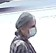

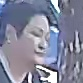

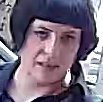

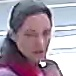

Для сравнения, точность на тестовых данных CelebA составляет 99.1%:

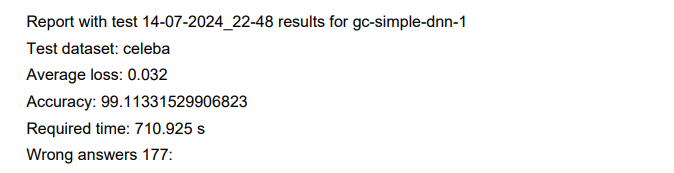

Теперь можно попробовать дообучить модель на "реальных данных":

In [ ]:
from sklearn.model_selection import KFold

output_teacher = "teacher.py"

if not os.path.exists(output_teacher):
    url_teacher = "https://drive.google.com/uc?export=download&id=1FlpmtUjgLqYYGSeWDKVZ_AeB_IvRQXPk"
    gdown.download(url_teacher, output_teacher, quiet=False)

from teacher import Teacher

# Use k-fold with splitting in 3 folds.
splits = 3
k_fold = KFold(n_splits=splits, shuffle=True)

# Choose optimizers, hyperparams and loss function
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

epochs = 1
batch_size = 17

model_name = 'gc-simple-dnn'

teacher = Teacher(device=device,
                  model_classifier=model,
                  model_name=model_name,
                  batch_size=batch_size,
                  loss_function=loss_function,
                  optimizer=optimizer,
                  )

print("\nStart training...\n")

for fold, (train_ids, test_ids) in enumerate(k_fold.split(data)):
    # Print
    print(f'\nFold -> {fold} ---------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_dataloader = torch.utils.data.DataLoader(
        data,
        batch_size=batch_size, sampler=train_subsampler)
    test_dataloader = torch.utils.data.DataLoader(
        data,
        batch_size=batch_size, sampler=test_subsampler)

    for epoch in range(epochs):
        # teacher.test(test_dataloader)
        print(f"\nEpoch {epoch + 1}/{epochs} -----------------")
        teacher.train(train_dataloader)
        print("\nStart testing...\n")
        teacher.test(test_dataloader)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1FlpmtUjgLqYYGSeWDKVZ_AeB_IvRQXPk
From (redirected): https://drive.google.com/uc?export=download&id=1FlpmtUjgLqYYGSeWDKVZ_AeB_IvRQXPk&confirm=t&uuid=fdbc6347-645f-49a5-94eb-108596b2fa15
To: /content/teacher.py
100%|██████████| 2.86k/2.86k [00:00<00:00, 8.59MB/s]


Start initializing Teacher
Using cuda device
Initializing models
Teacher initialized. Model is ready to be trained

Start training...


Fold -> 0 ---------------------

Epoch 1/1 -----------------

Start testing...

Test Error: 
 Accuracy: 100.0%, Avg batch loss: 0.001136 


Fold -> 1 ---------------------

Epoch 1/1 -----------------

Start testing...

Test Error: 
 Accuracy: 95.8%, Avg batch loss: 0.033661 


Fold -> 2 ---------------------

Epoch 1/1 -----------------

Start testing...

Test Error: 
 Accuracy: 100.0%, Avg batch loss: 0.000049 



Ввиду небольшого размера набора данных (73 изображения), для модели не составило труда запомнить новые изображения и точность составила 100%. Однако вывод об обобщающих способностях нейронной сети остаётся положительным, т.к. результат в 94% точности на фото, которые искуственная нейронная сеть не видела (обучалась на фото с идеальными условиями, освещенностью, лица строго в анфас), является неплохим результатом.